<a href="https://colab.research.google.com/github/ksahitreddy/Traffic-Data-Analysis-and-Forecasting/blob/main/Traffic%20Forecasting/Traffic_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split


import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs
from statsmodels.graphics.api import qqplot

from itertools import product
from tqdm.notebook import tqdm

In [ ]:
traffic_df = pd.read_csv('traffic.csv')

In [ ]:
traffic_df.shape

(48120, 4)

In [ ]:
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'])

In [ ]:
# set datetime to index
traffic_df.set_index('DateTime',inplace=True)
# check for null values
traffic_df.isnull().sum()

Junction    0
Vehicles    0
ID          0
dtype: int64

<Axes: xlabel='DateTime'>

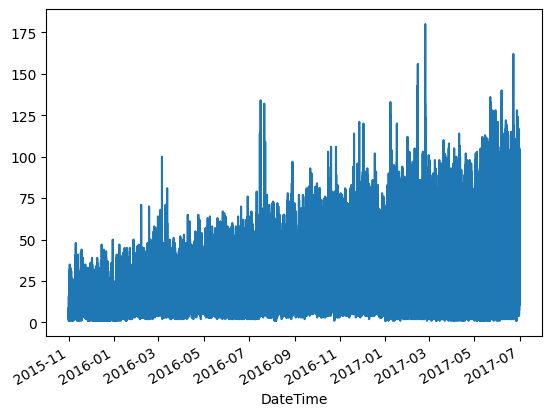

In [ ]:
traffic_df['Vehicles'].plot()

<Axes: xlabel='DateTime'>

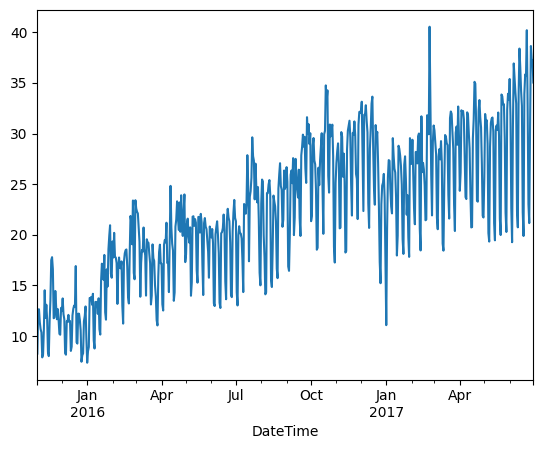

In [ ]:
daily = traffic_df.Vehicles.resample('D').mean()
daily.plot()

In [ ]:
def generate_sequences(ts: pd.Series, tw: int, pw: int):

    data = dict()

    L = len(ts)
    for i in range(L-tw):

        sequence = ts[i:i+tw].values
        sequence = np.reshape(sequence, (len(sequence),-1))

        target = ts[i+tw:i+tw+pw].values
        target = np.reshape(target, (len(target),-1))
        data[i] = {'sequence': sequence, 'target': target}
    return data

In [ ]:
class SequenceDataset(Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])

    def __len__(self):
        return len(self.data)

lookback = 7
n_pred = 1
sequences = generate_sequences(daily, lookback, n_pred)

In [ ]:
dataset = SequenceDataset(sequences)
split = 0.67 # Train/Test Split ratio
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]
lens

[402, 199]

In [ ]:
# random split of dataset into train and test set
train_ds, test_ds = random_split(dataset, lens)
BATCH_SIZE = 32 # Training batch size
# create dataloaders
r_trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
r_testloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# reshape the data to be used as an input for LSTM
daily_ts = daily.values.astype('float32')
daily_ts = np.reshape(daily_ts, (len(daily_ts),-1))

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, 32)
        self.fc = nn.Linear(32, output_size)

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.relu(output)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out
input_size = 1
hidden_size = 128
num_layers = 2
output_size = 1
model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback) #our lstm class
num_epochs = 200
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

In [ ]:
t_losses = []

for epoch in range(num_epochs):

    train_loss = 0.0

    model.train()

    for X_batch, y_batch in r_trainloader:
        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(r_trainloader)
    t_losses.append(epoch_loss)

    if epoch % 20 != 0:
        continue

    print("Epoch %d: MSE %.4f" % (epoch, epoch_loss))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: MSE 544.6428
Epoch 20: MSE 51.2382
Epoch 40: MSE 9.7987
Epoch 60: MSE 8.8861
Epoch 80: MSE 8.5946
Epoch 100: MSE 8.6348
Epoch 120: MSE 8.6712
Epoch 140: MSE 8.4508
Epoch 160: MSE 8.3072
Epoch 180: MSE 7.6892


In [ ]:
unshuffled_dataloader= DataLoader(dataset,shuffle=False)

In [ ]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
    model.eval()
    predictions, actuals = [], []
    for x, y in unshuffled_dataloader:
        with torch.no_grad():
            p = model(x)
            p = p[:,-1,:]
            predictions.append(p)
            actuals.append(y)
    predictions = torch.cat(predictions).numpy()
    actuals = torch.cat(actuals).numpy()
    return predictions, actuals.squeeze()
preds, actuals = make_predictions_from_dataloader(model, unshuffled_dataloader)
def one_step_forecast(model, history):

    model.eval()
    with torch.no_grad():
        pre = torch.Tensor(history).unsqueeze(0)
        pred = model(pre)
        pred = pred[:,-1,:]
    return pred.detach().numpy().reshape(-1)
forecast = one_step_forecast(model, daily_ts)
forecast

array([13.901828], dtype=float32)

In [ ]:
def n_step_forecast(data, model, lookback: int, n: int, forecast_from: int=None):

    history = data.copy()

    if forecast_from:
        pre = list(history[forecast_from - lookback : forecast_from])
    else:
        pre = list(history)[-lookback:]

    for i, step in enumerate(range(n)):
        pre_ = np.array(pre[-lookback:]).reshape(-1, 1)
        forecast = one_step_forecast(model, pre_)
        #forecast = forecast[:,-1,:]
        pre.append(forecast)

    res = history.copy()
    ls = [np.nan for i in range(len(history))]

    if forecast_from:
        ls[forecast_from : forecast_from + n] = list(np.array(pre[-n:]))
        res['forecast'] = ls
        res.columns = ['actual', 'forecast']
    else:
        fc = ls + list(np.array(pre[-n:]))
        ls = ls + [np.nan for i in range(len(pre[-n:]))]
        ls[:len(history)] = history
        res = pd.DataFrame([ls, fc], index=['actual', 'forecast']).T
        forecast = res.forecast[-n:]
        forecast.index = pd.date_range('2017-07-01', periods=n, freq='D')

    return forecast
lstm_forecast = n_step_forecast(daily_ts, model, lookback=7, n=30)

In [ ]:
# helper function to prepare modeled results
def prepare_results(model, preds, data, lookback):

    sample_plot = np.ones_like(data) * np.nan
    sample_plot[lookback:] = preds
    sample_df = pd.DataFrame(sample_plot, index=daily.index)
    return sample_df
modeled = prepare_results(model, preds, daily_ts, lookback=7)

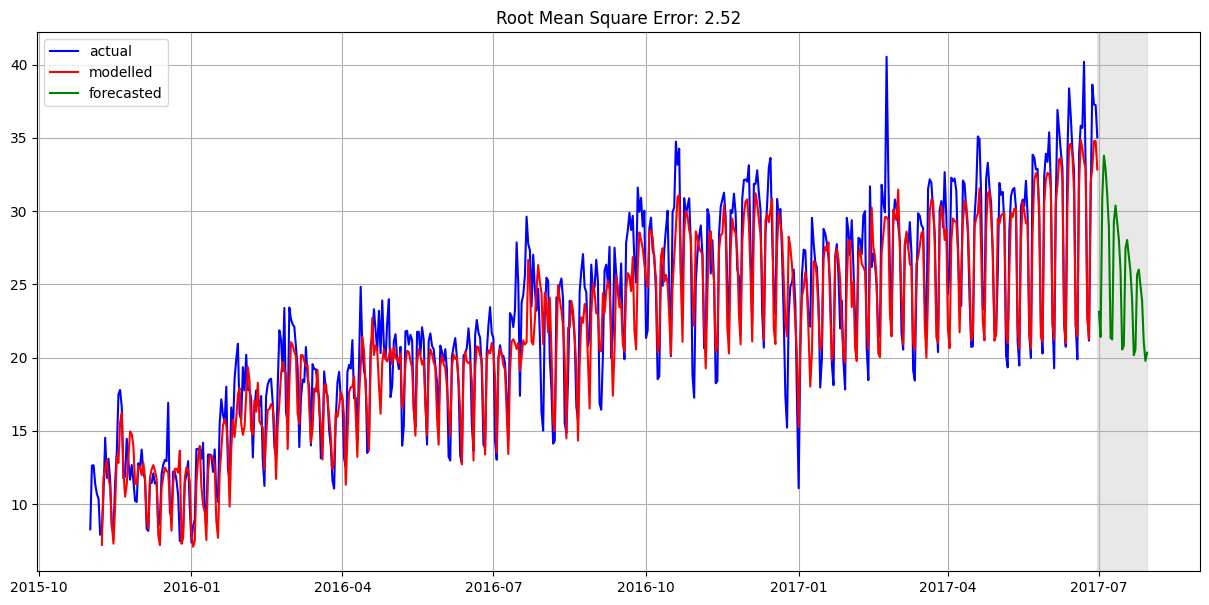

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_results(original, modeled, forecast):

    error = root_mean_squared_error(original[train_len+lookback+1:],modeled[train_len+lookback+1:])

    plt.figure(figsize=(15, 7))
    plt.title("Root Mean Square Error: {0:.2f}".format(error))
    plt.plot(original, c='b', label="actual")
    plt.plot(modeled, c='r', label="modelled")
    plt.plot(forecast, color='g', label="forecasted")
    plt.axvspan(original.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.legend()
    plt.grid(True);
plot_results(daily, modeled, lstm_forecast)